Import the libraries

In [407]:
from pydmd import DMD, BOPDMD
import numpy as np
import matplotlib.pyplot as plt
from pydmd.plotter import plot_eigs, plot_summary
from pydmd.preprocessing import hankel_preprocessing
from scipy.interpolate import griddata
import matplotlib.patches as mpatches

Import coordinate data and filter it to remove duplicates

In [409]:
coords = np.loadtxt('GD2_coords.csv', delimiter=',')

# Define bounds
D = 0.042
x_min = -5
x_max = 15
y_min = -5
y_max = 5
z_min = -0.001
z_max = 0.001

# Create masks
x_mask = (coords[:, 0]/D > x_min) & (coords[:, 0]/D < x_max)
y_mask = (coords[:, 1]/D > y_min) & (coords[:, 1]/D < y_max)
z_mask = (coords[:, 2]/D > z_min) & (coords[:, 2]/D < z_max)

combined_mask = x_mask & y_mask & z_mask

# Extract coordinates
filtered_coordinates = coords[combined_mask]

# Extract indices
filtered_indices = np.where(combined_mask)[0]

print("Filtered Coordinates:\n", filtered_coordinates)
print("Filtered Indices:\n", filtered_indices)

Filtered Coordinates:
 [[ 4.69999999e-01  1.64294124e-01  0.00000000e+00]
 [ 4.69999999e-01  2.03823537e-01  0.00000000e+00]
 [ 4.69999999e-01 -1.44529417e-01  0.00000000e+00]
 ...
 [-7.52986073e-02 -1.56845171e-02  1.51991841e-09]
 [-8.08472261e-02 -2.28400454e-02  1.51991841e-09]
 [-8.12254846e-02 -2.65417919e-02  1.51991841e-09]]
Filtered Indices:
 [  4966   4967   4969 ... 116265 116266 116267]


In [410]:
U0 = 0.1    # velocity
D = 0.042   # diameter

data = np.loadtxt('pressure.csv',delimiter=',')
data = data[filtered_indices,:]
snaps = data.shape[1] # number of snapshots
time = np.arange(0,snaps*0.25,0.25)*U0/D    # nondimensional time
dt = time[1] - time[0]

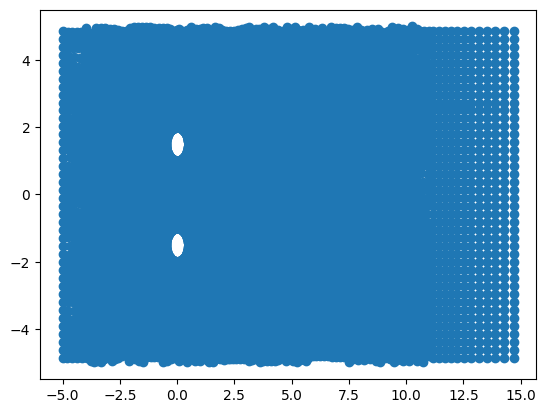

In [411]:
# check for bounding box
plt.scatter(filtered_coordinates[:, 0]/D, filtered_coordinates[:, 1]/D)
plt.show()

In [413]:
dmd = DMD(svd_rank=14)
dmd.fit(data)
dmd.original_time['dt'] = dt
dmd.original_time['t0'] = time[0]
dmd.original_time['tend'] = time[-1]

/Users/khawar/anaconda3/lib/python3.11/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 3815800.6919353483. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


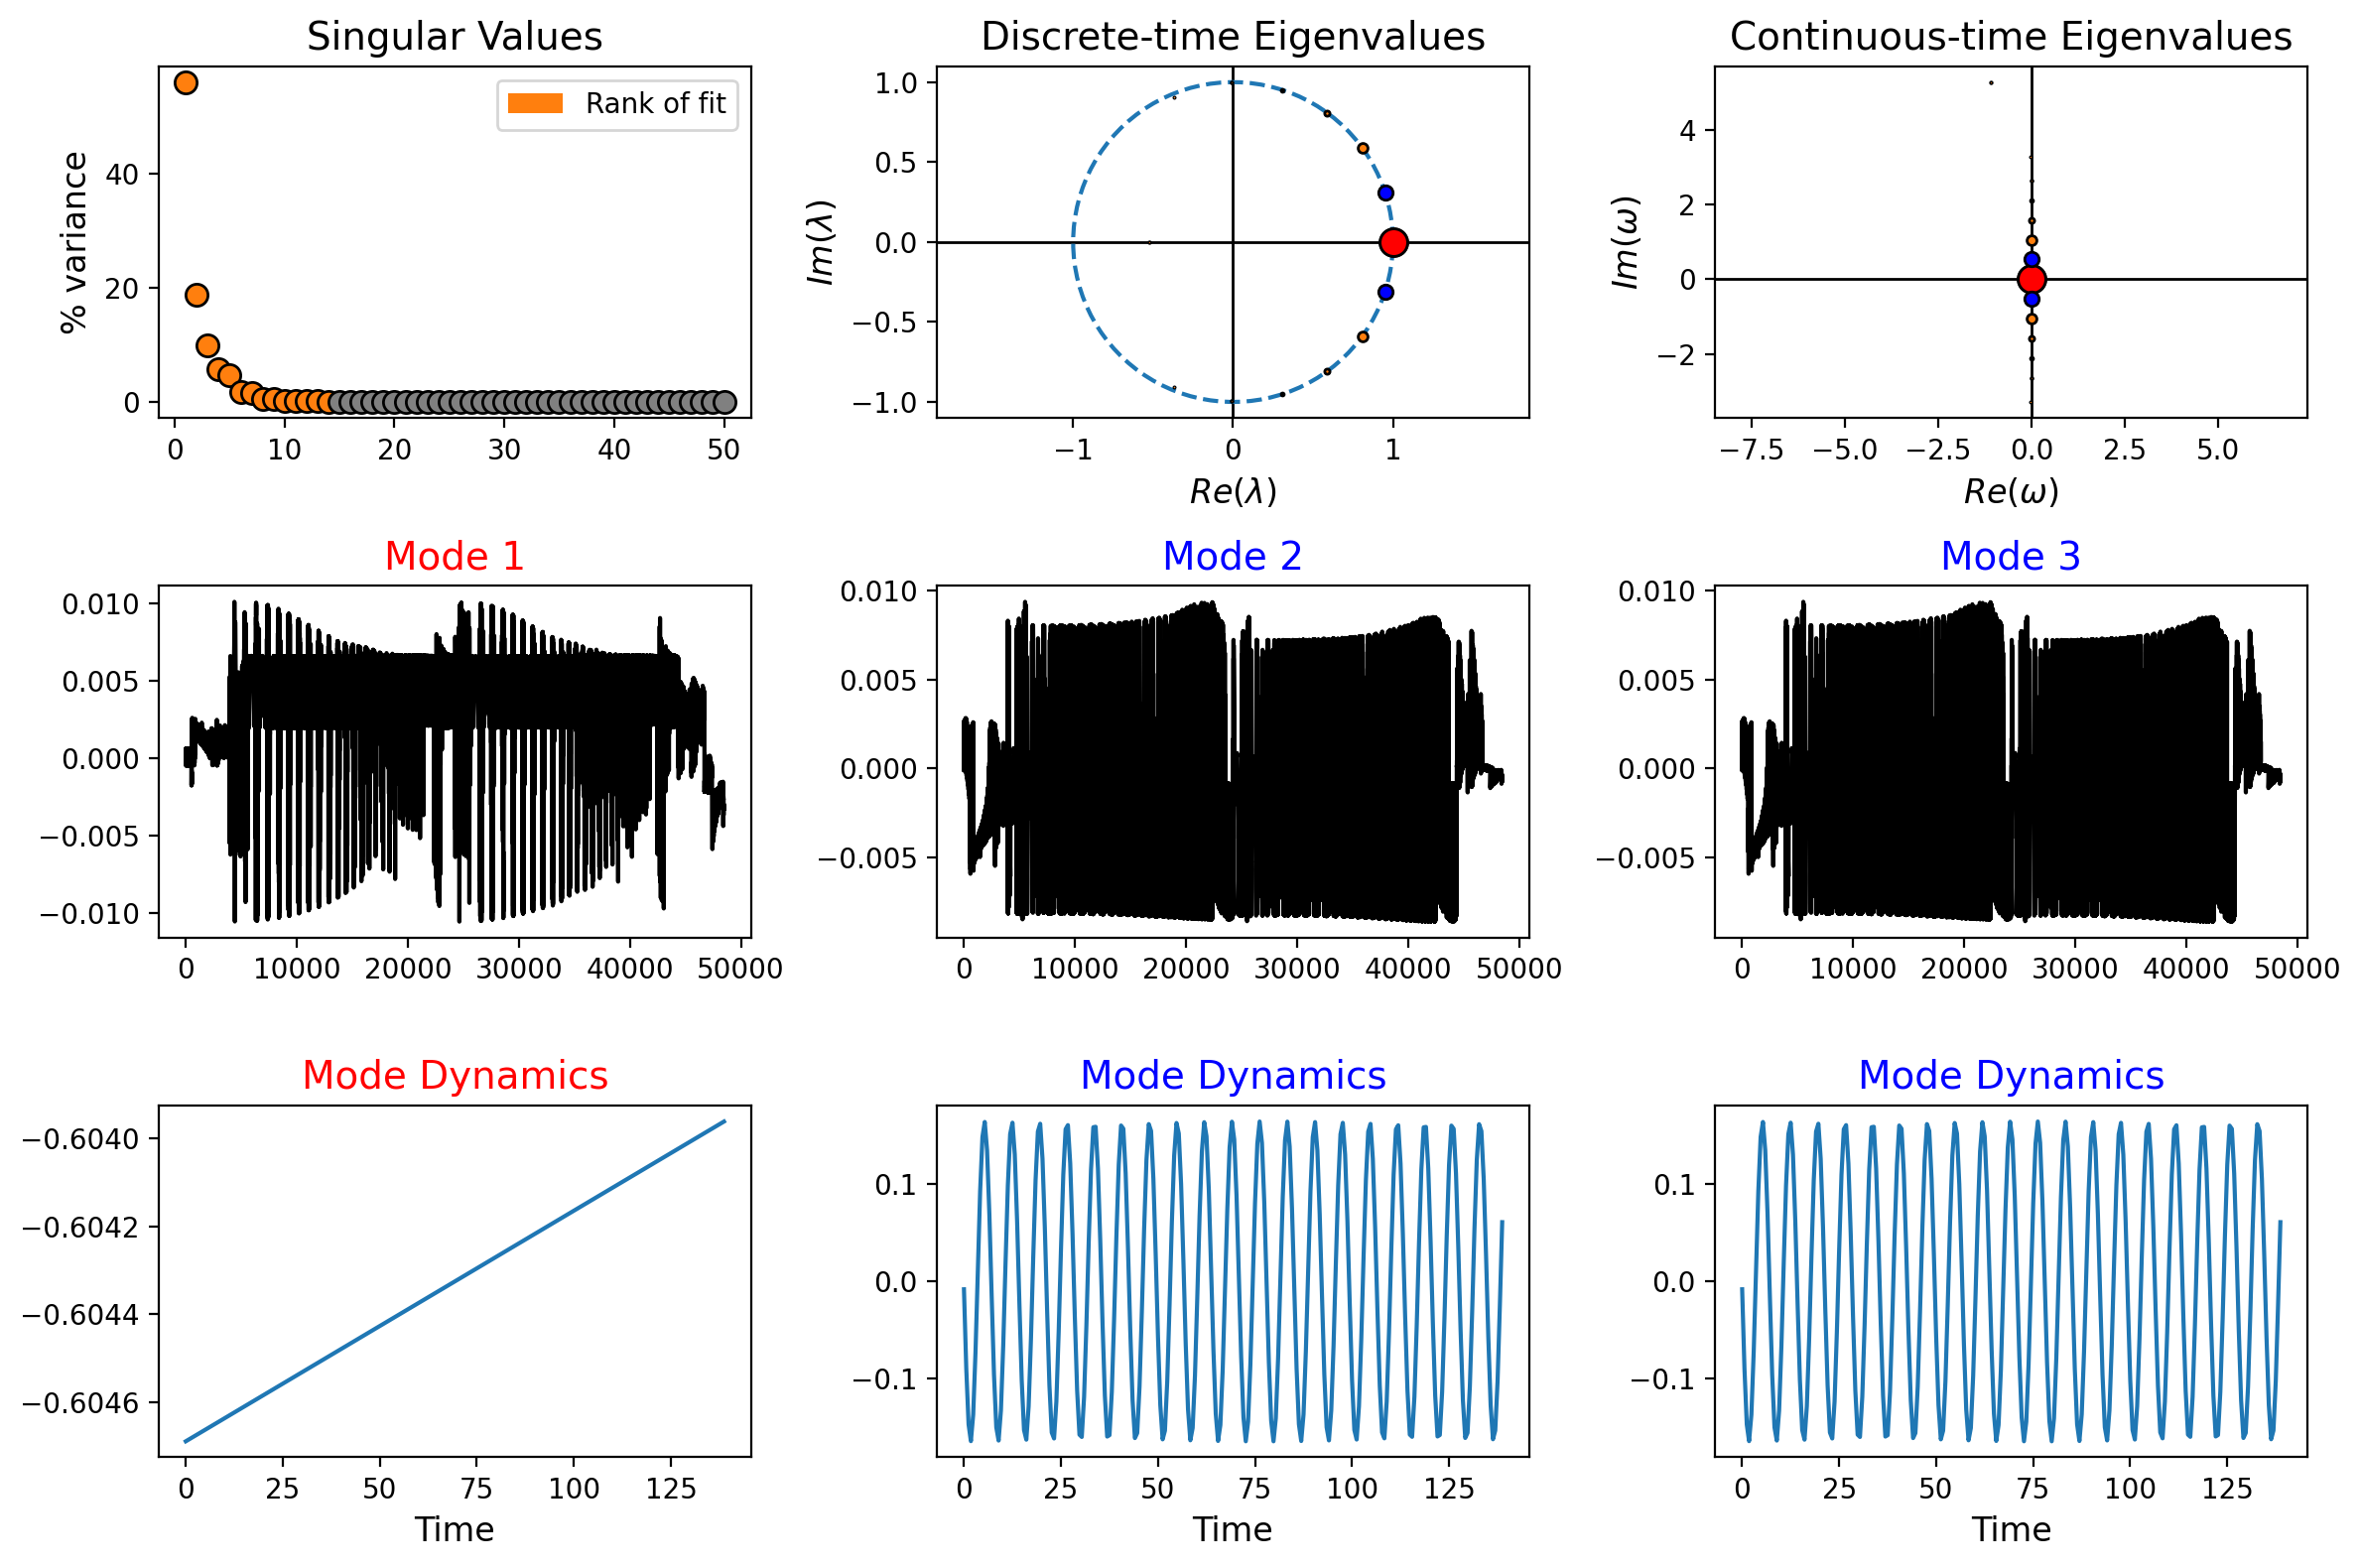

In [414]:
plot_summary(dmd,t=time)

In [415]:
freqs = np.imag(np.log(dmd.eigs)/dt)/(2*np.pi)
freqs

array([ 0.        ,  0.08391684, -0.08391684,  0.16783122, -0.16783122,
        0.25175434, -0.25175434,  0.84      ,  0.33583121, -0.33583121,
        0.5235301 , -0.5235301 ,  0.42172397, -0.42172397])

<StemContainer object of 3 artists>

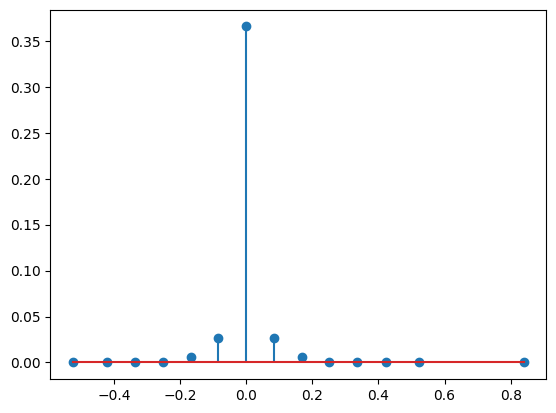

In [416]:
plt.stem(freqs,np.abs(dmd.amplitudes)**2)

In [417]:
amps = np.abs(dmd.amplitudes)
modes = dmd.modes.real


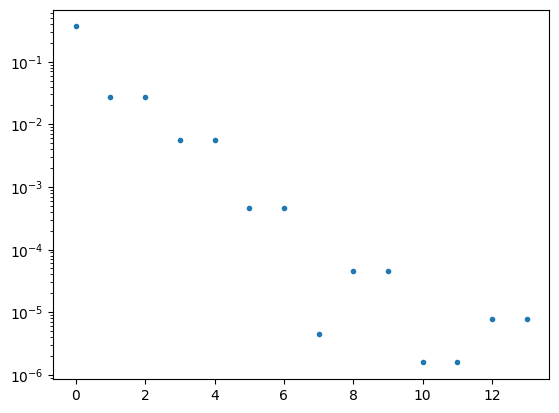

In [418]:
plt.semilogy(amps**2,'.')

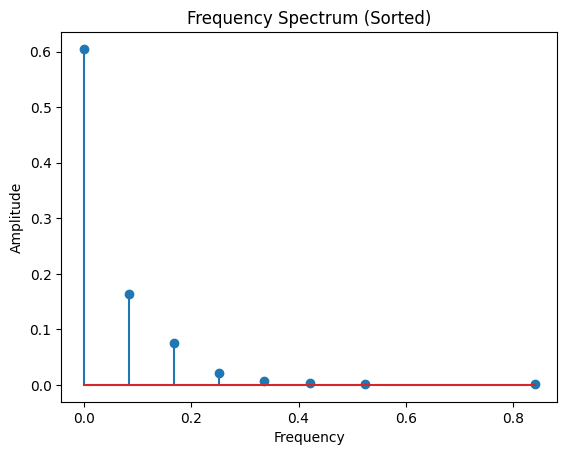

In [442]:
freqs = dmd.frequency
amps = np.abs(dmd.amplitudes)
modes = dmd.modes.real

# Sorting together efficiently:
sort_idx = np.argsort(amps)[::-1]  # Indices for descending sort based on amplitude
freqs = freqs[sort_idx]
amps = amps[sort_idx]
modes = modes[:, sort_idx]

# Filtering for positive frequencies in a single step:
positive_freq_mask = freqs >= 0
freqs = freqs[positive_freq_mask]
amps = amps[positive_freq_mask]
modes = modes[:, positive_freq_mask]

# Plotting:
plt.stem(freqs, amps)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Frequency Spectrum (Sorted)")  # Add a title
plt.show()


In [443]:
freqs

array([0.        , 0.08391684, 0.16783122, 0.25175434, 0.33583121,
       0.42172397, 0.84      , 0.5235301 ])

In [444]:
amps

array([0.60468756, 0.164438  , 0.07556251, 0.02135202, 0.00671065,
       0.00276527, 0.00211136, 0.00125186])

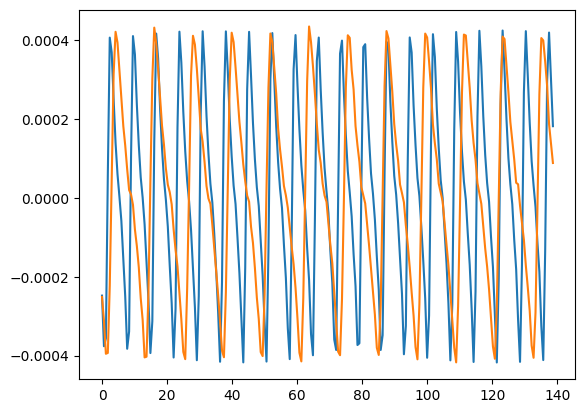

In [445]:
plt.plot(time, dmd.reconstructed_data.real[0,:])
plt.plot(time, data[0,:])
plt.show()

In [446]:
data[:,1]

array([-0.00031135, -0.00019494, -0.00060446, ...,  0.00212158,
        0.00213798,  0.00215873])

In [447]:
np.savetxt("pressure_dmd_modes_pydmd.csv", modes, delimiter=",", fmt="%f")


In [448]:
np.exp(np.real(np.log(dmd.eigs)))

array([0.99999694, 0.99999691, 0.99999691, 0.9999972 , 0.9999972 ,
       0.99994632, 0.99994632, 0.52406434, 0.9992778 , 0.9992778 ,
       0.97939219, 0.97939219, 0.99544214, 0.99544214])

In [456]:
def plot_contours(x,y,z,G,contours=25,nx=1000,ny=1000):
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

    X, Y = np.meshgrid(xi, yi)

    x_center1 = 0
    y_center1 = 0.5 + G/2
    x_center2 = 0
    y_center2 = -(0.5 + G/2)
    R = 0.5

    mask1 = (X - x_center1)**2 + (Y - y_center1)**2 <= R**2
    mask2 = (X - x_center2)**2 + (Y - y_center2)**2 <= R**2

    zi[mask1 | mask2] = np.nan  # Apply both masks

    theta = np.linspace(0, 2*np.pi, 200)
    a = 0.5 * np.cos( theta )
    b = 0.5 * np.sin( theta )

    width=0.000635/0.042
    length = 0.270/0.042
    rect1 = mpatches.Rectangle((x_center1, y_center1 - width/2), length+0.5, width, angle=0.0, color='gray', alpha=1)
    rect2 = mpatches.Rectangle((x_center2, y_center2 - width/2), length+0.5, width, angle=0.0, color='gray', alpha=1)
    
    

    fig, ax = plt.subplots(figsize=(20/2,10/2))
    plt.contourf(X, Y, zi, levels=contours, cmap='jet')
    plt.clim(-np.max(np.abs(z)), np.max(np.abs(z)))
    plt.fill(x_center1 + a, y_center1 + b, color='gray',alpha=1)
    plt.fill(x_center2 + a, y_center2 + b, color='gray',alpha=1)
    ax.add_patch(rect1)
    ax.add_patch(rect2)
    plt.colorbar()

    

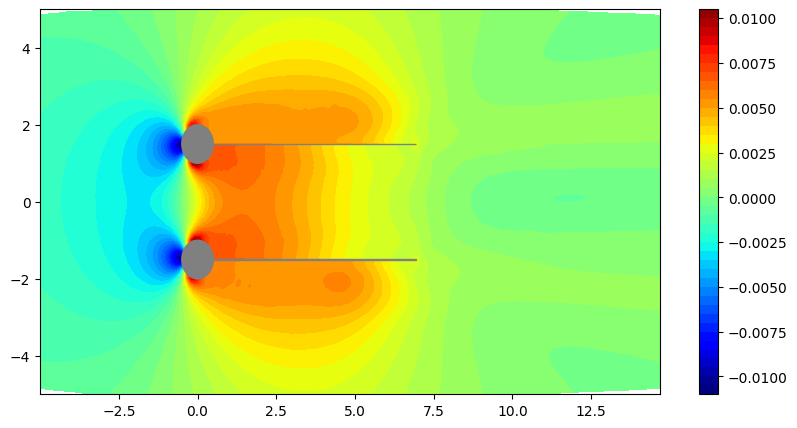

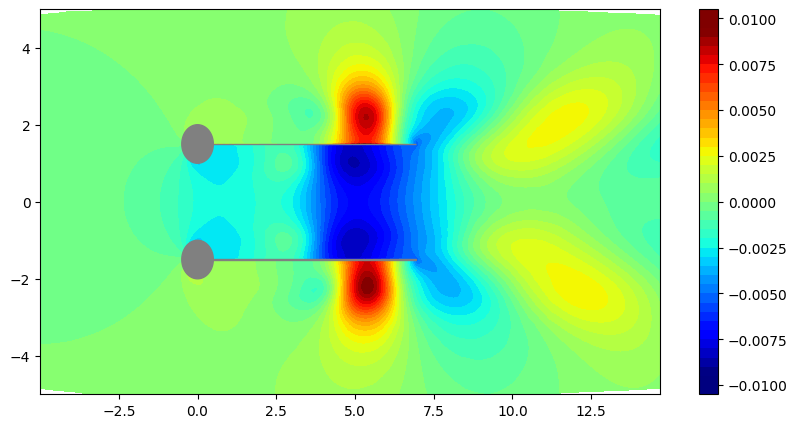

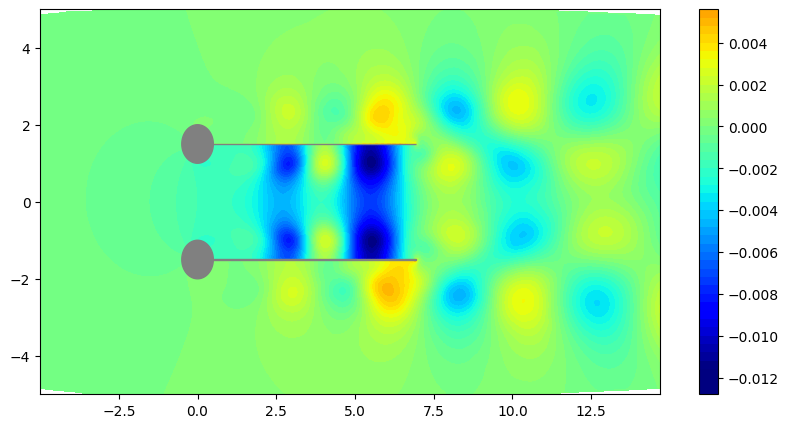

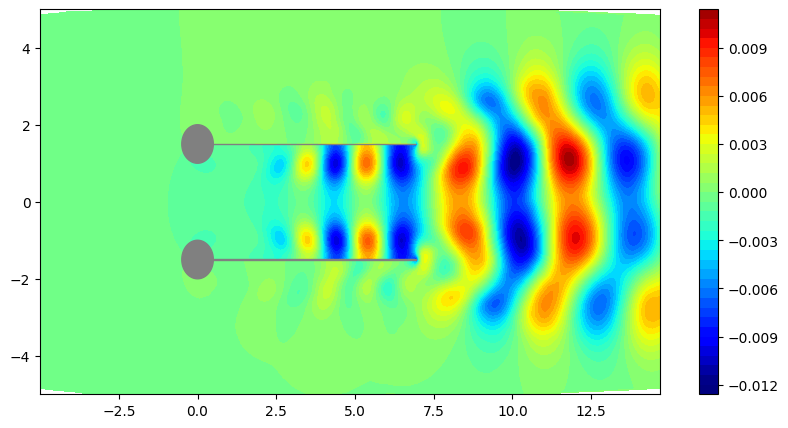

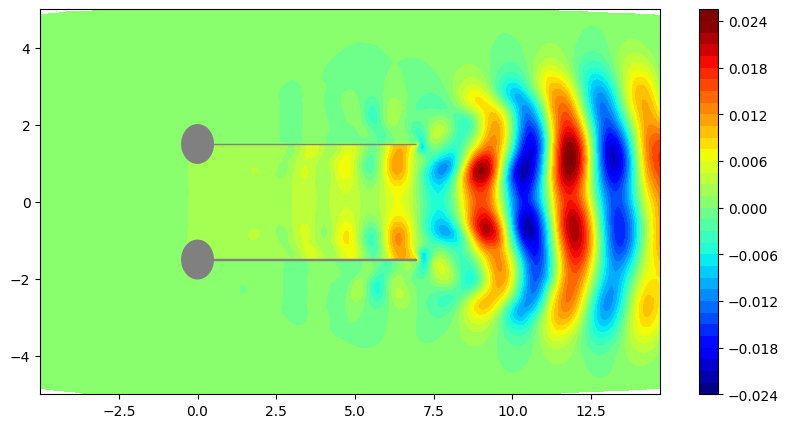

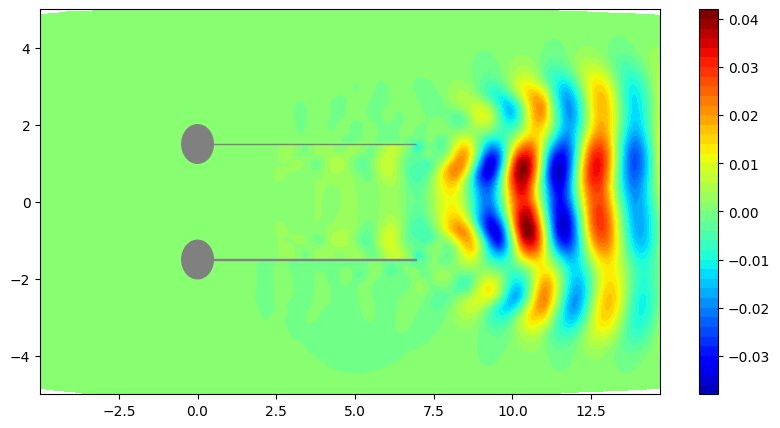

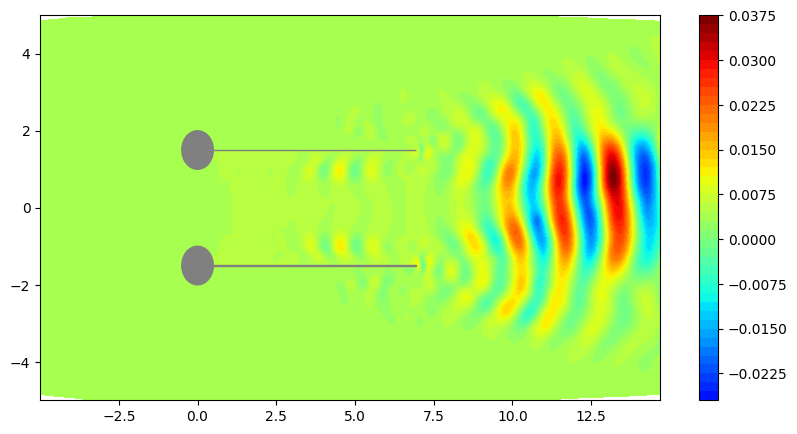

In [459]:
for i in range(7):
    plot_contours(filtered_coordinates[:,0]/D, filtered_coordinates[:,1]/D, modes[:,i],G=2, contours=45)
    plt.savefig('mode{}_local.pdf'.format(i+1))